<a href="https://colab.research.google.com/github/SeanRommes/Project-2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Heart Failure Prediction (Project 2)

Sean Rommes

# Heart Failure Prediction Dataset (dataset 1)
11 clinical features for predicting heart disease events.


##Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Description

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

## The Data

This DataSet is a classification problem which has 918 rows, 12 columns, and 11 features. My target will be if a person has heart disease or not. I see 5 categorical features which I will have to onehot encode. I'll check for any missing values, duplicated rows, and ensure all the columns are consistent with their types. Before I begin my ML models i'll check which features have the highest correlations to my target using a heat map, anything below .3 I'll drop before instantiating the train test split.

In [274]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn import set_config
set_config(display='diagram')


In [275]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo Course Work/Week 7: Logistic Regression and Regularization/True Heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [276]:
#getting number of rows and columns

df.shape

(918, 12)

# Cleaning the data

In [277]:
#getting an overview of types, searching for inconsistencies

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [278]:
# getting statistical values to search for unusual data points

df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


I see some unusual values, resting bp with a min value at 0 stands out to me, i'll check all the 0 min values just to be sure.

In [279]:
#checking missing values

df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [280]:
#checking number of unique values

df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [281]:
# checking for duplicates

df.duplicated().sum()

0

In [282]:
#checking for odd values in age

df['Age'].value_counts()

54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: Age, dtype: int64

In [283]:
#checking resting bp for abnormalities

df['RestingBP'].value_counts()

120    132
130    118
140    107
110     58
150     55
      ... 
185      1
98       1
92       1
113      1
164      1
Name: RestingBP, Length: 67, dtype: int64

In [284]:
# looking into 0 vale for bp as mentioned earlier, all results false.

df['RestingBP'] == 0

0      False
1      False
2      False
3      False
4      False
       ...  
913    False
914    False
915    False
916    False
917    False
Name: RestingBP, Length: 918, dtype: bool

In [285]:
# checking cholesterol. I find it odd that 172 people had a cholesterol level of 0.
# 0 cholesterol isnt impossible but I do find it unlikely for so many people. will replace 0
# with a median or mode imputer later on.

df['Cholesterol'].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: Cholesterol, Length: 222, dtype: int64

In [286]:
# checking values, TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic

df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [287]:
# checking fasting blood sugar column, looks like true or false values, does this mean that blood sugar levels were tested during fasting? or is this an error?
# data index reveals that this column is checking if fasting blood sugar is > 120 mg/dl  (1 = true; 0 = false)

df['FastingBS'].value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

In [288]:
# lvh is defined as left ventriclular hypertrophy and st as strain

df['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [289]:
# I didnt see any unusual values in max heart rate, but checking anyway.

df['MaxHR'].value_counts()

150    43
140    41
120    36
130    33
160    25
       ..
63      1
83      1
60      1
78      1
202     1
Name: MaxHR, Length: 119, dtype: int64

Max heartrate is measured using 220 minus your age. The lowest age in the dataset is 28 wich would mean 220 - 28 would put the highest max hr at 192. the highest age is 77, which would put the lowest max hr at 143. 202 or age 28 is a mistake as a max hr of 202 would put a person at the age of 18, which isnt present in this dataset. I'm going to keep the ages the same and consider changing all the invalid max hr outliers in this dataset to correspond to their appropriate values. However there maybe other factors in those people im not aware of that could make those outliers valid.

There are definitly some outliers in this column, particularly around the low end. I cant consider anything above 120 an outlier as there are multiple values, but all these single ones are definintly my outliers and i'm not sure if those are accurate or not based off my research alone, or if there are other medical factors involved with those people.

In [290]:
#oldpeak defined as ST(strain) depression induced by exercise relative to rest, i'm not sure how to interpret the negative values and will leave those alone,there's alot of 0's here as well, they might be missing values in disguise
# or just no reaction. i'll leave those the same for now.

df['Oldpeak'].value_counts()

 0.0    368
 1.0     86
 2.0     76
 1.5     53
 3.0     28
 1.2     26
 0.2     22
 0.5     19
 1.4     18
 1.8     17
 2.5     16
 0.8     16
 1.6     16
 0.1     14
 0.6     14
 0.4     11
 0.3     11
 4.0      8
 0.7      7
 2.8      7
 1.9      7
 1.3      7
 2.6      7
 1.1      7
 1.7      6
 2.2      5
 0.9      4
 2.4      4
 3.6      4
 3.4      3
 4.2      2
 3.5      2
-0.5      2
 2.3      2
 3.2      2
 2.1      2
-1.0      2
-0.1      2
 5.6      1
 2.9      1
 6.2      1
 3.8      1
-1.5      1
 3.1      1
-2.0      1
 3.7      1
-0.8      1
-0.7      1
-1.1      1
-2.6      1
-0.9      1
 5.0      1
 4.4      1
Name: Oldpeak, dtype: int64

In [291]:
# checking for unusual values in strain slope

df['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

#Visualizations

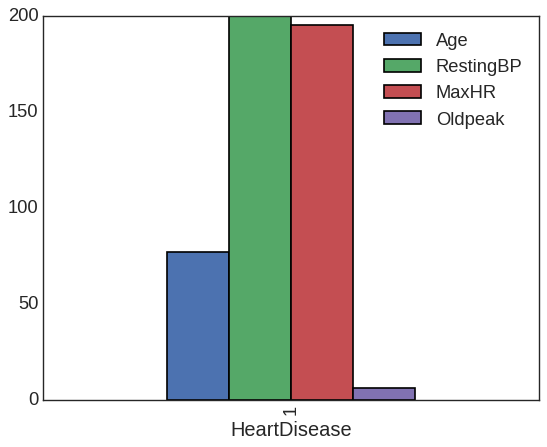

In [318]:

HDfilter = df['HeartDisease']==1
maxvalues = df.loc[HDfilter,:].groupby(['HeartDisease'])[['Age','Sex','RestingBP','MaxHR','Oldpeak']].max()
maxvalues.plot.bar();

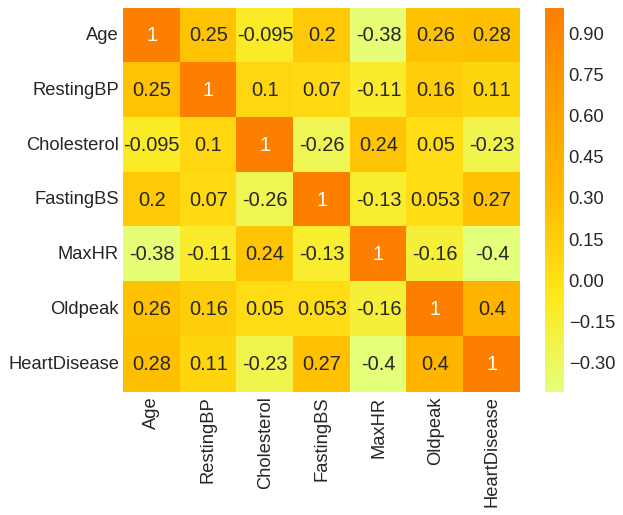

In [292]:
# I wanted to create a heatmap to view correlate factors

corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot = True)

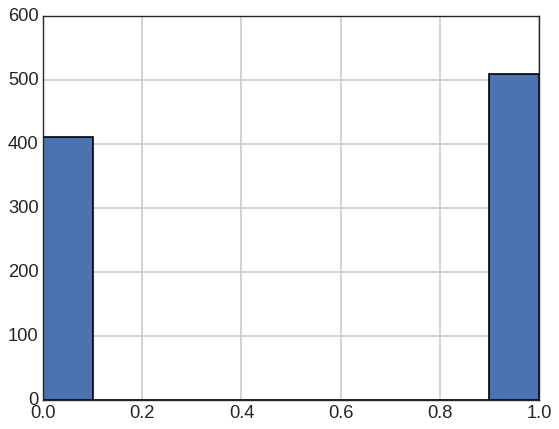

In [322]:
# this shows how many people did or did not have heart disease

df['HeartDisease'].hist();

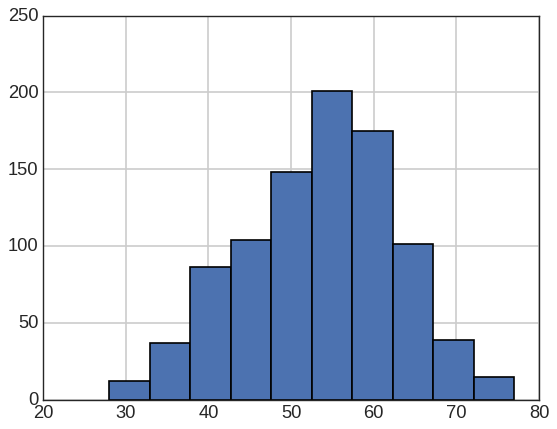

In [294]:
#most people in the sample are between 50 and 60

df['Age'].hist()

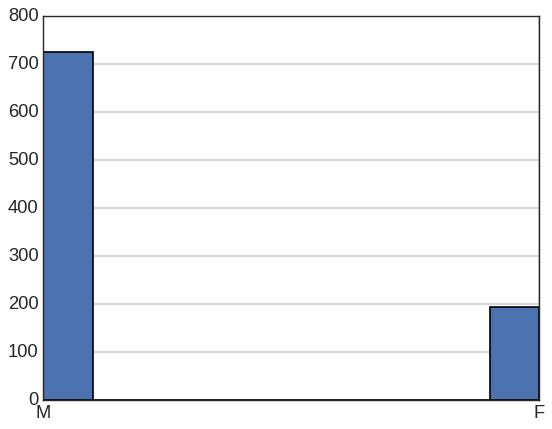

In [324]:
#this shows that most people in the sample were male

df['Sex'].hist()

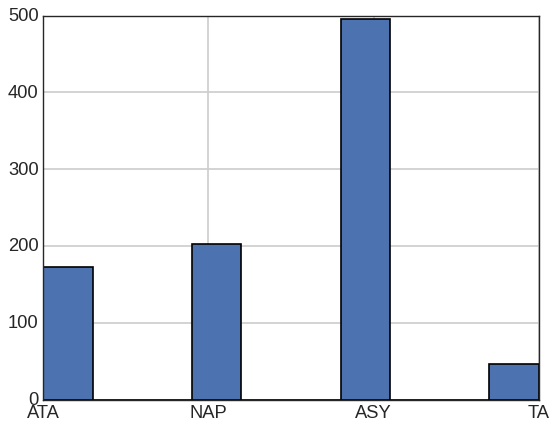

In [325]:
#Asymptomatic chestpain was the most common, meaning there was often no visual symptoms present in most people.

df['ChestPainType'].hist()

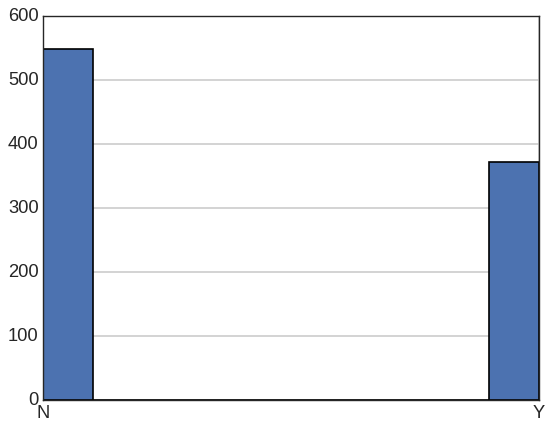

In [295]:
# angina during exercise is less common

df['ExerciseAngina'].hist();

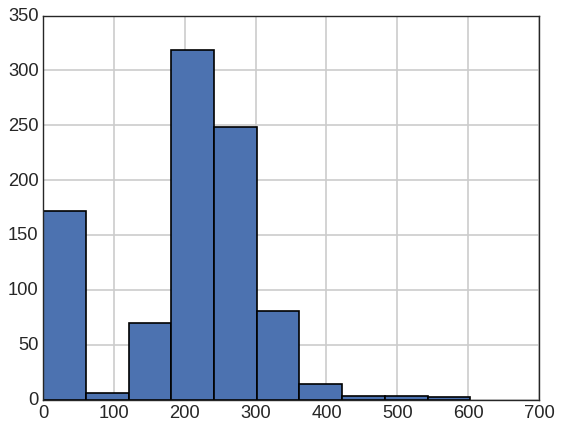

In [299]:
#most people had cholesterol between 200 and 300

df['Cholesterol'].hist();

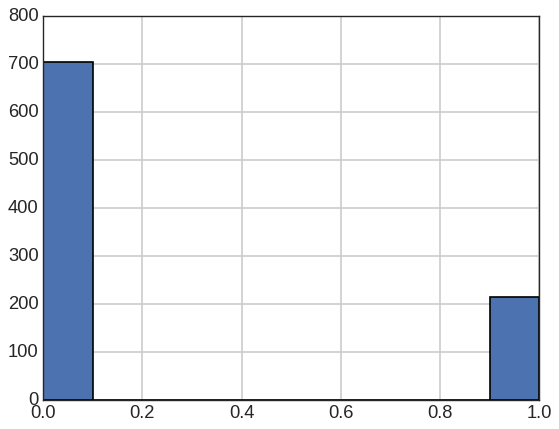

In [327]:
# this shows that over 700 people had fasting bloodsugar that was less than 120 mg

df['FastingBS'].hist()

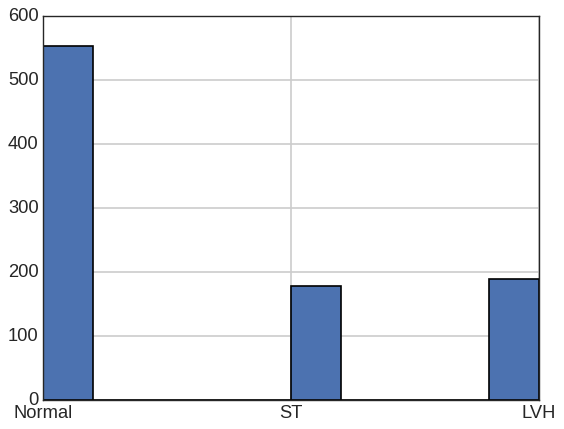

In [342]:
#most people had normal resting ecgs

df['RestingECG'].hist()

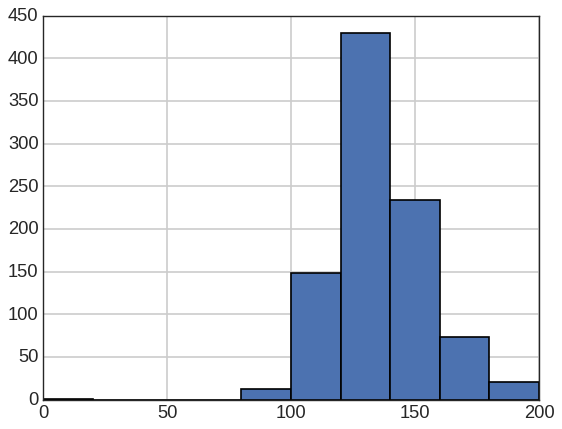

In [345]:
# a resting bp of 120-140 was most common

df['RestingBP'].hist()

This sample seems pretty well balanced, the heatmap above has surprisingly few strong correlates. Age seems to be the strongest factor, sex isnt measured here but ordinarily males are at a higher risk of heart disease according to https://gh.bmj.com/content/2/2/e000298

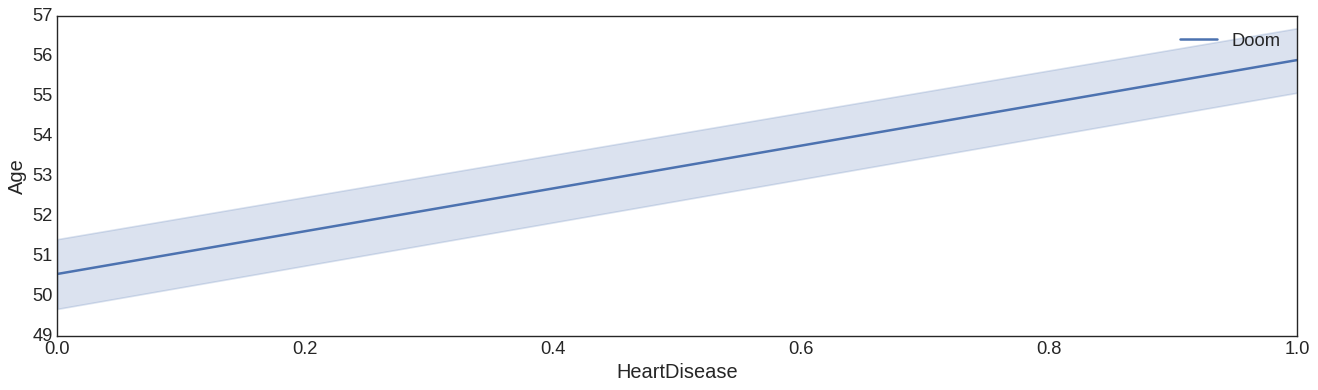

In [298]:
sns.set_context('talk')
plt.style.use('seaborn-white')
plt.figure(figsize= (20,5));
sns.lineplot(x = 'HeartDisease', y = 'Age', data = df, markers = ['S'],
             label = f'Doom');

This line graph tells us that the likelyhood of heart disease increases with age, particualarly around age 50.... and theres a 100% chance of it by 57... life is sad :(